In [69]:
# using Pkg
# Pkg.instantiate()

# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile

# Network metadata
num_neurons = 100
max_time = 3.5

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
_p = [1:num_neurons;] # Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
for (n, t) in eachrow(readdlm("data/Data v1.3/png_8s25i.txt", '\t', Float64, '\n'))
    push!(spikes, seq.Spike(_p[Int(n)], t))
end

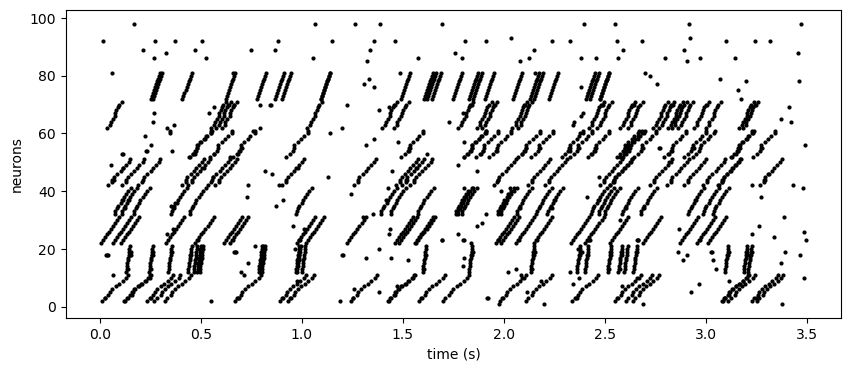

In [70]:
fig = seq.plot_raster(spikes; color="k") # returns matplotlib Figure
fig.set_size_inches([10, 4]);

## Specify PP-Seq model

There are a lot of hyperparameters associated with the pp-Seq model and the MCMC inference procedure. To make things as simple as possible, we create a "config dict" which specifies them all in one place. The table below summarizes the model hyperparameters.

| hyperparameter                | symbol         | Notes |
|:------------------------------|:--------------:|:---------------------|
| num_sequence_types            | $R$            | Number of unique sequence patterns
| seq_type_conc_param           | $\gamma$       | Specifies Dirichlet prior on sequence type probabilities
| seq_event_rate                | $\psi$         | Specifies homogeneous Poisson process for latent events
| mean_event_amplitude          |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with var_event_amplitude
| var_event_amplitude           |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with mean_event_amplitude
| neuron_response_conc_param    | $\varphi$      | Specifies Dirichlet prior on evoked response amplitudes in neural firing rate amplitudes
| neuron_offset_pseudo_obs      | $\kappa$       | Psuedo-observations on mean, Normal-Inverse-Chi-Squared prior
| neuron_width_pseudo_obs       | $\nu$          | Psuedo-observations on variance, Normal-Inverse-Chi-Squared prior 
| neuron_width_prior            | $\sigma^2$     | Variance parameter on Normal-Inverse-Chi-Squared prior
| mean_bkgd_spike_rate          | N/A            | Specifies the mean of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with var_bkgd_spike_rate)
| var_bkgd_spike_rate          | N/A            | Specifies the variance of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with mean_bkgd_spike_rate)
| bkgd_spikes_conc_param      | $\gamma_\varnothing$ | Specifies Dirichlet prior on relative background firing rates (supp. eq. #)

In [79]:
##################### Must tweak config according to data ##########################################
config = Dict(

    # Model hyperparameters
    :num_sequence_types =>  10,  # Types of sequences in data. Overestimating is better
    :seq_type_conc_param => 1.0,  # Assumes every sequence is equally likely (fair assumption)
    :seq_event_rate => 57.0,  # No. of sequences/sec.

    :mean_event_amplitude => 10.0,  # Avg. number of spikes per sequence (10 for our purposes)
    :var_event_amplitude => 1.5,  # Small because it's always 10 for us, may increase for other purposes
    
    :neuron_response_conc_param => 0.1,  # Idk, I thought a spike's a spike
    :neuron_offset_pseudo_obs => 0.01,  # Average delay between neurons in sequence (10 ms)
    :neuron_width_pseudo_obs => 1.0, # Causes it to train for much longer if increased
    :neuron_width_prior => 0.0001,  #  Tolerance (in sec.) for noisy delays in a sequence
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,

    :mean_bkgd_spike_rate => 104.0,  # No. of non-sequence spikes / sec.
    :var_bkgd_spike_rate => 10.0,  # Variance is tight cuz we know the sequences
    :bkgd_spikes_conc_param => 0.5,  # Longer training if decreased
    :max_sequence_length => 12.0,  # Self-explanatory. All sequences rn are 10 spikes
    
    # MCMC Sampling parameters.
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 1700,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 15,  # Increasing helps reduce mislabeled dupe sequences
    :split_merge_moves_after_anneal => 20,  # Same as above
    :split_merge_window => 1.0,

);

In [80]:
# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes, init_assignments, config);

(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-

## Plot results

#### Plot raster plot with labeled sequences

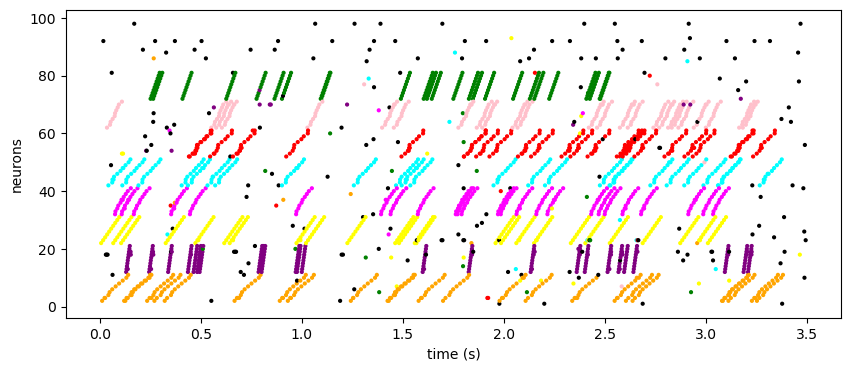

In [81]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = [1:num_neurons;] 
# seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = seq.plot_raster(
    spikes,
    final_events,
    final_assignments,
    neuron_ordering;
    color_cycle=["red", "blue", "yellow", "green", "orange", "purple", "pink", "cyan", "magenta", "gray"] # colors for each sequence type can be modified.
)
fig.set_size_inches([10, 4]);

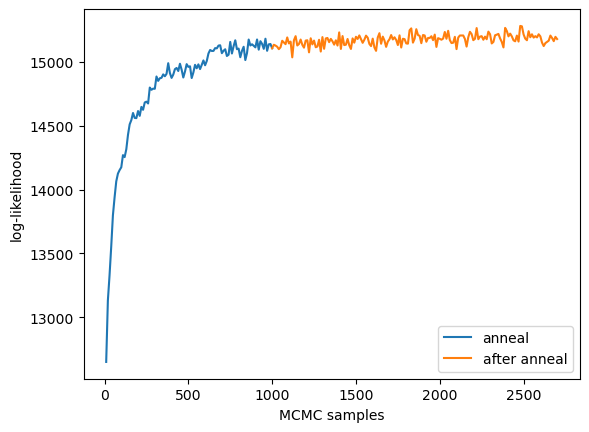

In [83]:
seq.plot_log_likes(config, results);

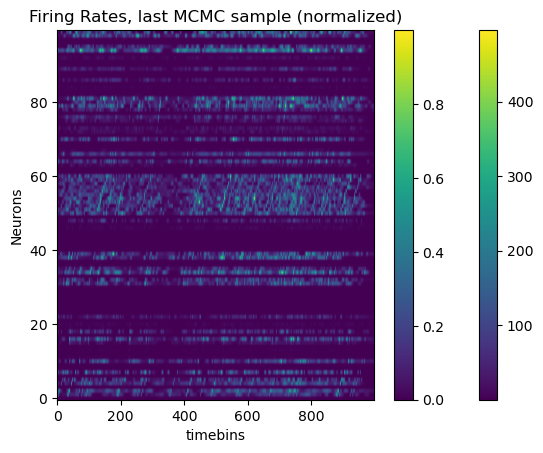

In [82]:
# Create discrete time grid.
num_timebins = 1000
dt = max_time / num_timebins
timebins = collect((0.5 * dt):dt:max_time)

# Compute a matrix firing rates (num_neurons x num_timebins)
F = seq.firing_rates(
    final_globals,
    final_events,
    timebins
)

# Plot firing rates as a heatmap
plt.imshow(F[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Firing Rates, last MCMC sample (spikes / second)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();
F_nrm = copy(F)
for n in 1:num_neurons
    F_nrm[n, :] .-= minimum(F[n, :])
    F_nrm[n, :] ./= maximum(F[n, :])
end

plt.title("Firing Rates, last MCMC sample (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.imshow(F_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.colorbar();